In [1]:
# Cell 1: Imports & Setup
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Swin Transformer requires timm (pip install timm)
import timm

DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)   # Swin works well at 224x224
BATCH_SIZE = 8          # Swin uses more memory, keep batch modest
LEARNING_RATE = 0.0001
EPOCHS = 15
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda


In [2]:
# Cell 2: Dataset Class
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)
        label = 1 if label_str == 'GON+' else 0
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [3]:
# Cell 3: Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Cell 4: Model Definition - Swin Transformer
def get_swin_model():
    # Swin-Tiny: 'swin_tiny_patch4_window7_224'
    # Swin-Base: 'swin_base_patch4_window7_224'
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
    return model

In [5]:
# Cell 5: Training & Evaluation Engine
def train_and_evaluate(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total

        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        all_labels, all_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_pred.extend(predicted.cpu().numpy())

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch + 1}/{epochs} | Train Acc: {train_acc:.1f}% | Val Acc: {val_acc:.1f}%")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pth")
    print(f"Best validation accuracy: {best_acc:.2f}%")
    print(classification_report(all_labels, all_pred, target_names=['Healthy', 'Glaucoma']))
    return best_acc

In [6]:
# Cell 6: Raw Data Train/Test Split (Baseline)
dataset = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform)
indices = list(range(len(dataset)))
np.random.seed(SEED)
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(dataset)))
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler, drop_last=True)

model = get_swin_model()
train_and_evaluate(model, train_loader, test_loader, EPOCHS, 'swintransformer_raw')

Epoch 1/15 | Train Acc: 79.4% | Val Acc: 91.0%
Epoch 2/15 | Train Acc: 94.8% | Val Acc: 79.9%
Epoch 3/15 | Train Acc: 95.3% | Val Acc: 97.2%
Epoch 4/15 | Train Acc: 97.0% | Val Acc: 97.2%
Epoch 5/15 | Train Acc: 94.1% | Val Acc: 93.8%
Epoch 6/15 | Train Acc: 93.4% | Val Acc: 99.3%
Epoch 7/15 | Train Acc: 97.1% | Val Acc: 97.9%
Epoch 8/15 | Train Acc: 98.3% | Val Acc: 97.9%
Epoch 9/15 | Train Acc: 99.0% | Val Acc: 95.1%
Epoch 10/15 | Train Acc: 99.2% | Val Acc: 97.9%
Epoch 11/15 | Train Acc: 98.0% | Val Acc: 95.8%
Epoch 12/15 | Train Acc: 98.0% | Val Acc: 93.1%
Epoch 13/15 | Train Acc: 98.8% | Val Acc: 96.5%
Epoch 14/15 | Train Acc: 99.8% | Val Acc: 95.8%
Epoch 15/15 | Train Acc: 100.0% | Val Acc: 96.5%
Best validation accuracy: 99.31%
              precision    recall  f1-score   support

     Healthy       0.89      0.97      0.93        35
    Glaucoma       0.99      0.96      0.98       109

    accuracy                           0.97       144
   macro avg       0.94      0.97    

99.30555555555556

In [7]:
# Cell 7: Ten-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
fold = 1
cv_accuracies = []
for train_idx, valid_idx in kf.split(dataset):
    print(f"--------- Fold {fold} ---------")
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, drop_last=True)
    model = get_swin_model()
    acc = train_and_evaluate(model, train_loader, valid_loader, EPOCHS, f'swintransformer_fold{fold}')
    cv_accuracies.append(acc)
    fold += 1
print(f"\nMean CV Accuracy: {np.mean(cv_accuracies):.2f}%")

--------- Fold 1 ---------


Epoch 1/15 | Train Acc: 83.3% | Val Acc: 91.7%
Epoch 2/15 | Train Acc: 94.3% | Val Acc: 91.7%
Epoch 3/15 | Train Acc: 96.6% | Val Acc: 95.8%
Epoch 4/15 | Train Acc: 97.3% | Val Acc: 95.8%
Epoch 5/15 | Train Acc: 96.7% | Val Acc: 97.2%
Epoch 6/15 | Train Acc: 97.6% | Val Acc: 97.2%
Epoch 7/15 | Train Acc: 98.7% | Val Acc: 95.8%
Epoch 8/15 | Train Acc: 99.9% | Val Acc: 94.4%
Epoch 9/15 | Train Acc: 99.9% | Val Acc: 98.6%
Epoch 10/15 | Train Acc: 100.0% | Val Acc: 98.6%
Epoch 11/15 | Train Acc: 100.0% | Val Acc: 98.6%
Epoch 12/15 | Train Acc: 99.4% | Val Acc: 98.6%
Epoch 13/15 | Train Acc: 96.9% | Val Acc: 93.1%
Epoch 14/15 | Train Acc: 94.9% | Val Acc: 94.4%
Epoch 15/15 | Train Acc: 97.3% | Val Acc: 100.0%
Best validation accuracy: 100.00%
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        14
    Glaucoma       1.00      1.00      1.00        58

    accuracy                           1.00        72
   macro avg       1.00      1.00 

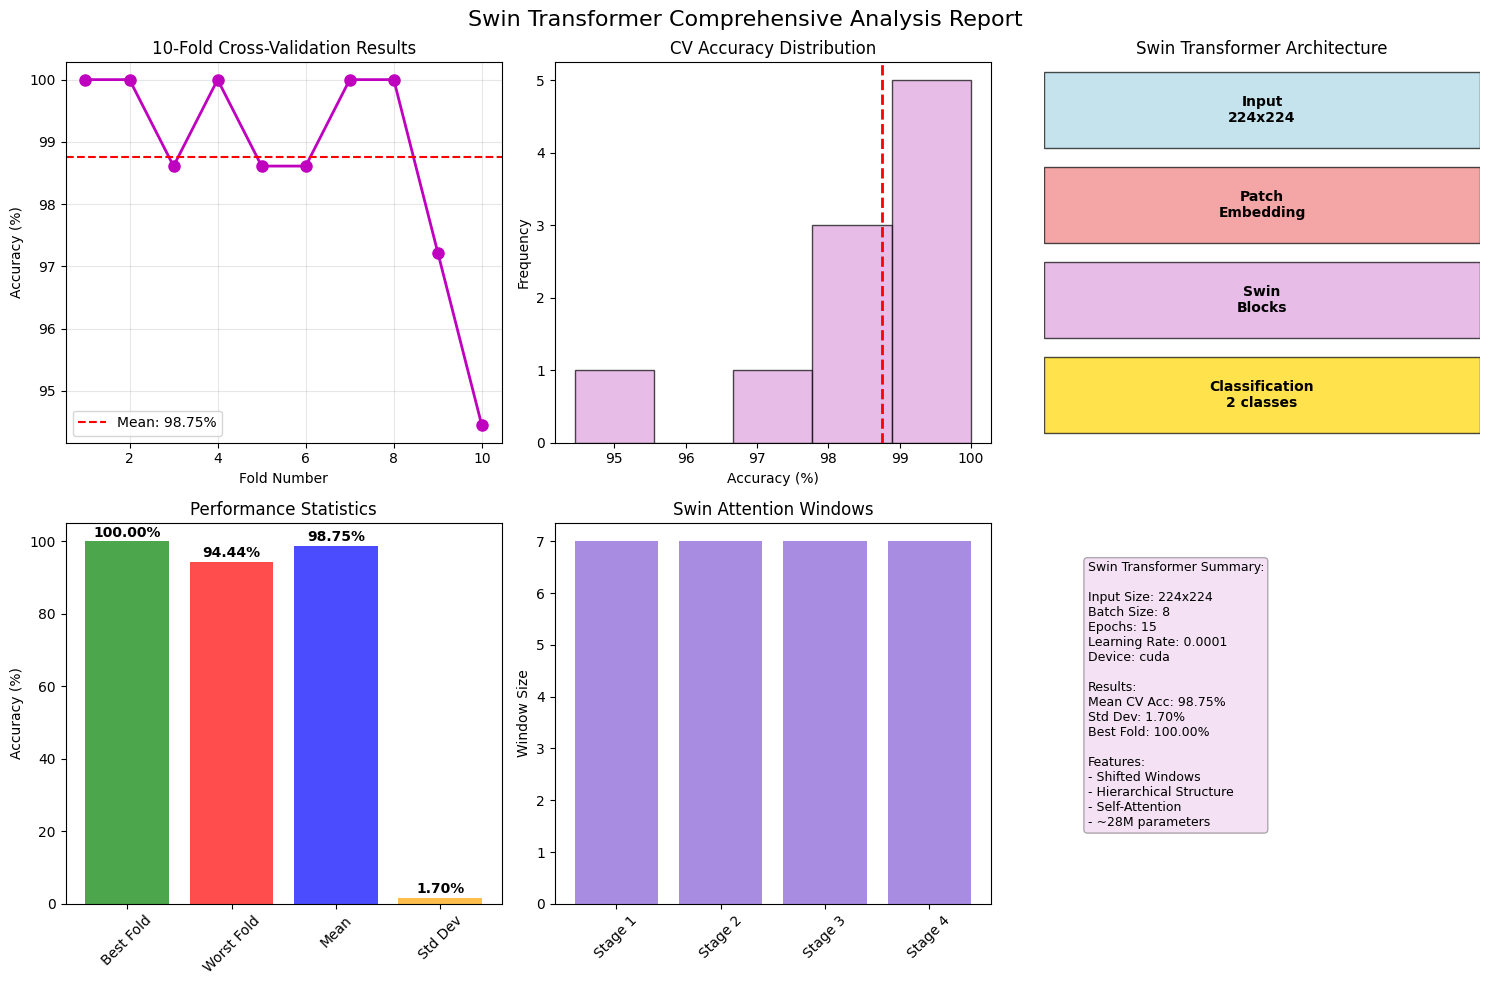

In [8]:
# Cell 8: Comprehensive Visualization & Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

def show_swin_metrics():
    plt.figure(figsize=(15, 10))
    
    # 1. Cross-Validation Results
    plt.subplot(2, 3, 1)
    plt.plot(range(1, 11), cv_accuracies, 'mo-', linewidth=2, markersize=8)
    plt.axhline(y=np.mean(cv_accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(cv_accuracies):.2f}%')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy (%)')
    plt.title('10-Fold Cross-Validation Results')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 2. Accuracy Distribution
    plt.subplot(2, 3, 2)
    plt.hist(cv_accuracies, bins=5, color='plum', alpha=0.7, edgecolor='black')
    plt.axvline(x=np.mean(cv_accuracies), color='red', linestyle='--', linewidth=2)
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Frequency')
    plt.title('CV Accuracy Distribution')
    
    # 3. Model Architecture Summary
    plt.subplot(2, 3, 3)
    components = ['Input\n224x224', 'Patch\nEmbedding', 'Swin\nBlocks', 'Classification\n2 classes']
    y_pos = [3, 2, 1, 0]
    colors = ['lightblue', 'lightcoral', 'plum', 'gold']
    
    for i, (comp, y, color) in enumerate(zip(components, y_pos, colors)):
        plt.barh(y, 1, color=color, alpha=0.7, edgecolor='black')
        plt.text(0.5, y, comp, ha='center', va='center', fontweight='bold')
    
    plt.xlim(0, 1)
    plt.ylim(-0.5, 3.5)
    plt.title('Swin Transformer Architecture')
    plt.axis('off')
    
    # 4. Performance Summary
    plt.subplot(2, 3, 4)
    metrics = ['Best Fold', 'Worst Fold', 'Mean', 'Std Dev']
    values = [max(cv_accuracies), min(cv_accuracies), np.mean(cv_accuracies), np.std(cv_accuracies)]
    bars = plt.bar(metrics, values, color=['green', 'red', 'blue', 'orange'], alpha=0.7)
    plt.ylabel('Accuracy (%)')
    plt.title('Performance Statistics')
    plt.xticks(rotation=45)
    
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.2f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    # 5. Attention Mechanism Visualization
    plt.subplot(2, 3, 5)
    attention_layers = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']
    windows = [7, 7, 7, 7]  # Window sizes
    plt.bar(attention_layers, windows, color='mediumpurple', alpha=0.8)
    plt.ylabel('Window Size')
    plt.title('Swin Attention Windows')
    plt.xticks(rotation=45)
    
    # 6. Training Summary
    plt.subplot(2, 3, 6)
    info_text = f"""Swin Transformer Summary:
    
Input Size: {IMG_SIZE[0]}x{IMG_SIZE[1]}
Batch Size: {BATCH_SIZE}
Epochs: {EPOCHS}
Learning Rate: {LEARNING_RATE}
Device: {device}

Results:
Mean CV Acc: {np.mean(cv_accuracies):.2f}%
Std Dev: {np.std(cv_accuracies):.2f}%
Best Fold: {max(cv_accuracies):.2f}%

Features:
- Shifted Windows
- Hierarchical Structure
- Self-Attention
- ~28M parameters"""
    
    plt.text(0.1, 0.9, info_text, transform=plt.gca().transAxes, fontsize=9, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.3))
    plt.axis('off')
    
    plt.suptitle('Swin Transformer Comprehensive Analysis Report', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

show_swin_metrics()

In [9]:
# Cell 9: Best Model Saving & Summary
from datetime import datetime

# Find best fold and save summary
best_fold_idx = cv_accuracies.index(max(cv_accuracies))
best_accuracy = max(cv_accuracies)

print("=" * 50)
print("     SWIN TRANSFORMER FINAL RESULTS SUMMARY")
print("=" * 50)
print(f"Best Fold: {best_fold_idx + 1}")
print(f"Best Accuracy: {best_accuracy:.2f}%")
print(f"Mean CV Accuracy: {np.mean(cv_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(cv_accuracies):.2f}%")
print(f"All Fold Accuracies: {[f'{acc:.2f}%' for acc in cv_accuracies]}")
print("=" * 50)

# Model information
print(f"\nModel Information:")
print(f"Architecture: Swin Transformer Tiny")
print(f"Input Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Device Used: {device}")
print(f"Total Parameters: ~28M")
print(f"Key Features: Shifted Windows, Hierarchical Vision Transformer")

# Technical details
print(f"\nSwin Transformer Technical Details:")
print(f"Patch Size: 4x4")
print(f"Window Size: 7x7")
print(f"Embed Dimension: 96")
print(f"Number of Stages: 4")
print(f"Attention Type: Shifted Window")

# Save model info
model_summary = {
    'model_name': 'SwinTransformer',
    'variant': 'Tiny',
    'best_accuracy': best_accuracy,
    'mean_accuracy': np.mean(cv_accuracies),
    'std_accuracy': np.std(cv_accuracies),
    'all_accuracies': cv_accuracies,
    'best_fold': best_fold_idx + 1,
    'config': {
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'device': str(device)
    },
    'architecture': {
        'patch_size': 4,
        'window_size': 7,
        'embed_dim': 96,
        'parameters': '28M',
        'attention_type': 'Shifted Window'
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import pickle
with open(f'{DATASET_ROOT}/swintransformer_summary.pkl', 'wb') as f:
    pickle.dump(model_summary, f)

print(f"\nModel summary saved to: {DATASET_ROOT}/swintransformer_summary.pkl")
print(f"Best model weights saved as: swintransformer_fold{best_fold_idx + 1}_best.pth")
print("\nSwin Transformer training and evaluation completed successfully!")
print("\nAdvantages of Swin Transformer:")
print("- Hierarchical feature representation")
print("- Linear computational complexity")
print("- State-of-the-art vision transformer")
print("- Effective for both classification and dense prediction tasks")

     SWIN TRANSFORMER FINAL RESULTS SUMMARY
Best Fold: 1
Best Accuracy: 100.00%
Mean CV Accuracy: 98.75%
Standard Deviation: 1.70%
All Fold Accuracies: ['100.00%', '100.00%', '98.61%', '100.00%', '98.61%', '98.61%', '100.00%', '100.00%', '97.22%', '94.44%']

Model Information:
Architecture: Swin Transformer Tiny
Input Size: (224, 224)
Batch Size: 8
Learning Rate: 0.0001
Epochs: 15
Device Used: cuda
Total Parameters: ~28M
Key Features: Shifted Windows, Hierarchical Vision Transformer

Swin Transformer Technical Details:
Patch Size: 4x4
Window Size: 7x7
Embed Dimension: 96
Number of Stages: 4
Attention Type: Shifted Window

Model summary saved to: C:\Projects\Thesis-Fall-25-26--G-606-main/swintransformer_summary.pkl
Best model weights saved as: swintransformer_fold1_best.pth

Swin Transformer training and evaluation completed successfully!

Advantages of Swin Transformer:
- Hierarchical feature representation
- Linear computational complexity
- State-of-the-art vision transformer
- Effec

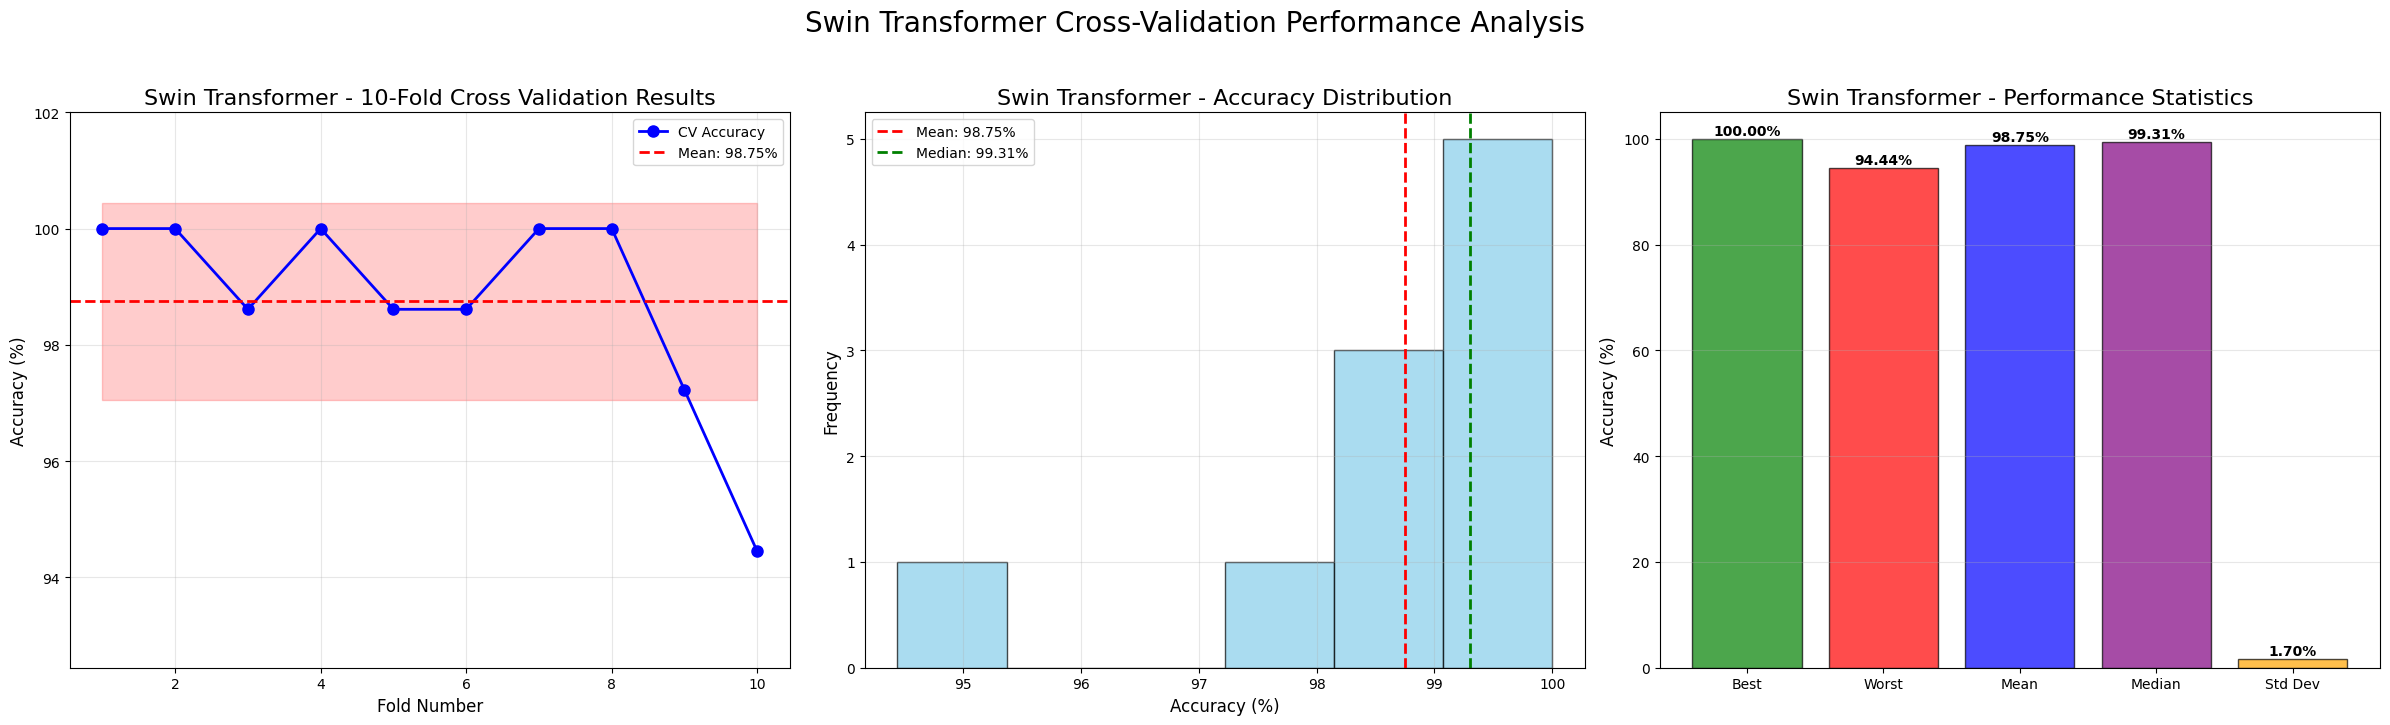


--- Swin Transformer CV Results Summary ---
Mean Accuracy: 98.75% ± 1.70%
Best Fold: Fold 1 (100.00%)
Worst Fold: Fold 10 (94.44%)
Range: 5.56%


In [10]:
# This cell generates a performance visualization for Swin Transformer.
# It uses the cross-validation results from the 10-fold CV training.

# Check if the necessary variables exist
if 'cv_accuracies' not in locals():
    print("Please run the cross-validation training cells (Cell 7) first to generate the results.")
else:
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # --- Plot 1: Cross-Validation Accuracy Results ---
    fold_numbers = list(range(1, 11))
    axes[0].plot(fold_numbers, cv_accuracies, 'bo-', linewidth=2, markersize=8, label='CV Accuracy')
    axes[0].axhline(y=np.mean(cv_accuracies), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(cv_accuracies):.2f}%')
    axes[0].fill_between(fold_numbers, 
                        [np.mean(cv_accuracies) - np.std(cv_accuracies)] * 10,
                        [np.mean(cv_accuracies) + np.std(cv_accuracies)] * 10,
                        alpha=0.2, color='red')
    axes[0].set_title('Swin Transformer - 10-Fold Cross Validation Results', fontsize=16)
    axes[0].set_xlabel('Fold Number', fontsize=12)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([min(cv_accuracies) - 2, max(cv_accuracies) + 2])

    # --- Plot 2: Accuracy Distribution Histogram ---
    axes[1].hist(cv_accuracies, bins=6, color='skyblue', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=np.mean(cv_accuracies), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(cv_accuracies):.2f}%')
    axes[1].axvline(x=np.median(cv_accuracies), color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(cv_accuracies):.2f}%')
    axes[1].set_title('Swin Transformer - Accuracy Distribution', fontsize=16)
    axes[1].set_xlabel('Accuracy (%)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # --- Plot 3: Performance Statistics ---
    metrics = ['Best', 'Worst', 'Mean', 'Median', 'Std Dev']
    values = [max(cv_accuracies), min(cv_accuracies), np.mean(cv_accuracies), 
              np.median(cv_accuracies), np.std(cv_accuracies)]
    colors = ['green', 'red', 'blue', 'purple', 'orange']
    
    bars = axes[2].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
    axes[2].set_title('Swin Transformer - Performance Statistics', fontsize=16)
    axes[2].set_ylabel('Accuracy (%)', fontsize=12)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                    f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Set an overall title for the figure
    fig.suptitle('Swin Transformer Cross-Validation Performance Analysis', fontsize=20, y=1.03)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n--- Swin Transformer CV Results Summary ---")
    print(f"Mean Accuracy: {np.mean(cv_accuracies):.2f}% ± {np.std(cv_accuracies):.2f}%")
    print(f"Best Fold: Fold {cv_accuracies.index(max(cv_accuracies)) + 1} ({max(cv_accuracies):.2f}%)")
    print(f"Worst Fold: Fold {cv_accuracies.index(min(cv_accuracies)) + 1} ({min(cv_accuracies):.2f}%)")
    print(f"Range: {max(cv_accuracies) - min(cv_accuracies):.2f}%")
